## Librerias

In [1]:
import pandas as pd
import numpy as np
import time
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
from scipy.optimize import minimize

## Datos

In [2]:
df = pd.read_excel("Datos_Portafolio_Markowitz.xlsx", sheet_name="Activos")
retornos = df.set_index("Fecha")
retornos.index = pd.to_datetime(retornos.index)
# Cambiar nombres de columnas: de '.' a '-' en retornos
retornos.columns = retornos.columns.str.replace(".", "-")

In [3]:
retornos

,AGUAS-A,CHILE,BCI,ITAUCL,BSANTANDER,CAP,CENCOSUD,COLBUN,CCU,VAPORES,...,LTM,PARAUCO,MALLPLAZA,QUINENCO,RIPLEY,SALFACORP,SMU,SQM-B,SONDA,CONCHATORO
Fecha,,,,,,,,,,,,,,,,,,,,,
2022-01-04,-0.007887,0.039333,0.034357,-0.006042,0.030945,-0.019906,0.006501,-0.042508,-0.002782,-0.003987,...,-0.109199,-0.055727,-0.046031,0.020664,-0.011116,0.000000,-0.005190,-0.037536,0.057451,-0.004069
2022-01-05,0.022510,0.033529,0.014424,0.018019,0.008825,0.022718,-0.002884,0.027693,-0.022392,-0.000933,...,0.051497,-0.002474,-0.022130,0.002765,0.010383,-0.025947,0.014351,-0.015735,0.024599,0.025368
2022-01-06,0.029997,0.028640,0.018975,-0.016807,0.020653,-0.036348,-0.018215,-0.013070,0.004955,-0.020739,...,-0.002817,0.014566,0.012886,0.002869,0.010929,0.000000,0.053809,0.018130,0.037344,0.012373
2022-01-07,0.026444,-0.017887,-0.019160,0.028642,-0.004853,0.001800,-0.011091,-0.024957,-0.025158,0.004074,...,0.007409,-0.029782,-0.033376,0.037923,-0.009172,-0.036293,0.002050,-0.008650,0.043185,-0.007435
2022-01-10,-0.023943,0.015915,0.011834,0.000588,0.026668,-0.016466,0.011091,-0.027188,-0.000432,-0.052871,...,-0.044769,0.039128,0.046086,0.005018,0.005397,-0.000264,0.013065,-0.026630,-0.005682,0.011206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-12-20,0.006152,0.001064,-0.003832,-0.001969,0.002535,-0.013912,-0.013857,0.021573,-0.009869,-0.014043,...,0.005822,0.000970,-0.013245,0.025407,-0.001827,0.000036,-0.000621,0.003811,0.012551,-0.005306
2024-12-23,0.007874,-0.002752,-0.013832,-0.010002,-0.017022,0.000039,0.009259,-0.005594,-0.003889,-0.003542,...,-0.013148,0.006767,-0.006384,-0.003181,-0.005988,-0.018182,-0.006231,-0.017279,0.000528,-0.012704
2024-12-24,-0.002776,0.004435,-0.001430,0.003180,0.008547,-0.003649,-0.002307,-0.008163,-0.000017,0.007257,...,0.010241,0.010986,-0.002749,0.009796,-0.000038,0.009278,-0.001313,-0.000217,0.006972,-0.004944


## Portafolio

In [4]:
# PARÁMETROS
mean_returns = retornos.mean()
num_assets = len(mean_returns)
rf = 0.0474 / 252  # tasa libre de riesgo diaria

constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

In [5]:
# FUNCIONES DE OPTIMIZACIÓN
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, risk

def neg_sharpe_ratio(weights, mean_returns, cov_matrix, risk_free_rate):
    ret, risk = portfolio_performance(weights, mean_returns, cov_matrix)
    return -(ret - risk_free_rate) / risk

def min_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# Portafolio de máximo retorno esperado
def neg_return(weights, mean_returns):
    return -np.dot(weights, mean_returns)

# FUNCIÓN PARA MOSTRAR RESULTADOS
def mostrar_resultados(resultado, nombre):
    ret, risk = portfolio_performance(resultado.x, mean_returns, cov_matrix)
    sharpe = (ret - rf) / risk
    print(f"\n{nombre}")
    print(f"Retorno esperado: {ret:.5f}")
    print(f"Riesgo (desviación estándar): {risk:.5f}")
    print(f"Sharpe Ratio: {sharpe:.5f}")
    pesos = pd.Series(resultado.x, index=retornos.columns)
    print("\nPesos del portafolio:")
    print(pesos.round(4))
    return pd.DataFrame(pesos.round(4), columns=[nombre])

In [6]:
# CÁLCULO DE ESTADÍSTICAS
mean_returns = retornos.mean()
cov_matrix = retornos.cov()
num_assets = len(mean_returns)

# RESTRICCIONES Y PARÁMETROS
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

# OPTIMIZACIÓN 
# Portafolio de mínima varianza
res_min_var = minimize(min_variance, initial_guess, args=(cov_matrix,),
                       method='SLSQP', bounds=bounds, constraints=constraints)

# Portafolio de máximo retorno esperado
res_max_ret = minimize(neg_return, initial_guess, args=(mean_returns,),
                       method='SLSQP', bounds=bounds, constraints=constraints)

# Portafolio de máximo Sharpe
res_max_sharpe = minimize(neg_sharpe_ratio, initial_guess,
                          args=(mean_returns, cov_matrix, rf),
                          method='SLSQP', bounds=bounds, constraints=constraints)

# RESULTADOS
# MOSTRAR LOS RESULTADOS DE CADA PORTAFOLIO
resultado_1_min = mostrar_resultados(res_min_var, "Portafolio de Mínima Varianza")
resultado_1_max = mostrar_resultados(res_max_ret, "Portafolio de Máximo Retorno Esperado")
resultado_1_sharpe = mostrar_resultados(res_max_sharpe, "Portafolio de Máximo Sharpe Ratio")


Portafolio de Mínima Varianza
Retorno esperado: 0.00046
Riesgo (desviación estándar): 0.00925
Sharpe Ratio: 0.02896

Pesos del portafolio:
AGUAS-A       0.0347
CHILE         0.0349
BCI           0.0346
ITAUCL        0.0010
BSANTANDER    0.0347
CAP           0.0343
CENCOSUD      0.0347
COLBUN        0.0346
CCU           0.0348
VAPORES       0.0343
ANDINA-B      0.0349
ENTEL         0.0348
CMPC          0.0345
COPEC         0.0345
ENELAM        0.0348
ENELCHILE     0.0345
ECL           0.0344
FALABELLA     0.0345
SECURITY      0.0349
IAM           0.0346
LTM           0.0295
PARAUCO       0.0346
MALLPLAZA     0.0347
QUINENCO      0.0347
RIPLEY        0.0345
SALFACORP     0.0345
SMU           0.0348
SQM-B         0.0341
SONDA         0.0347
CONCHATORO    0.0350
dtype: float64

Portafolio de Máximo Retorno Esperado
Retorno esperado: 0.01238
Riesgo (desviación estándar): 0.31608
Sharpe Ratio: 0.03856

Pesos del portafolio:
AGUAS-A       0.0
CHILE         0.0
BCI           0.0
ITAUCL       

## Integración factor de ajuste

In [7]:
def mostrar_resultados(resultado, nombre, cov_matrix):
    ret, risk = portfolio_performance(resultado.x, mean_returns, cov_matrix)
    sharpe = (ret - rf) / risk
    print(f"\n{nombre}")
    print(f"Retorno esperado: {ret:.5f}")
    print(f"Riesgo (desviación estándar): {risk:.5f}")
    print(f"Sharpe Ratio: {sharpe:.5f}")
    pesos = pd.Series(resultado.x, index=retornos.columns)
    print("\nPesos del portafolio:")
    print(pesos.round(4))
    return pd.DataFrame(pesos.round(4), columns=[nombre])

In [8]:
# CARGAR DATOS
archivo = "Datos_Portafolio_Markowitz.xlsx"
ajustes_df = pd.read_excel(archivo, sheet_name="Probabilidades")
ajustes = ajustes_df.set_index("Activo")["Ajuste"]

# Asegurar que nombres coincidan
retornos = retornos[ajustes.index]

# CONSTRUIR MATRIZ DE COVARIANZA AJUSTADA
# Matriz de correlación original
cor_matrix = retornos.corr()
# Desviaciones estándar históricas
std_original = retornos.std()
# Desviaciones ajustadas
peso = 0.2
ajustes = 1 - peso * ajustes
std_ajustada = std_original * ajustes
# Nueva matriz de covarianza ajustada
cov_ajustada = np.outer(std_ajustada, std_ajustada) * cor_matrix
cov_ajustada = pd.DataFrame(cov_ajustada, index=ajustes.index, columns=ajustes.index)

# OPTIMIZACIÓN
res_min_var_adj = minimize(min_variance, initial_guess, args=(cov_ajustada,),
                           method='SLSQP', bounds=bounds, constraints=constraints)

res_max_ret_adj = minimize(neg_return, initial_guess, args=(mean_returns,),
                           method='SLSQP', bounds=bounds, constraints=constraints)

res_max_sharpe_adj = minimize(neg_sharpe_ratio, initial_guess,
                              args=(mean_returns, cov_ajustada, rf),
                              method='SLSQP', bounds=bounds, constraints=constraints)


# VISUALIZAR
resultado_2_min = mostrar_resultados(res_min_var_adj, "Portafolio de Mínima Varianza (Ajustado)", cov_ajustada)
resultado_2_max = mostrar_resultados(res_max_ret_adj, "Portafolio de Máximo Retorno (Ajustado)", cov_ajustada)
resultado_2_sharpe = mostrar_resultados(res_max_sharpe_adj, "Portafolio de Máximo Sharpe (Ajustado)", cov_ajustada)


Portafolio de Mínima Varianza (Ajustado)
Retorno esperado: 0.00045
Riesgo (desviación estándar): 0.00949
Sharpe Ratio: 0.02802

Pesos del portafolio:
AGUAS-A       0.0349
CHILE         0.0352
BCI           0.0346
ITAUCL        0.0000
BSANTANDER    0.0349
CAP           0.0342
CENCOSUD      0.0349
COLBUN        0.0347
CCU           0.0349
VAPORES       0.0342
ANDINA-B      0.0352
ENTEL         0.0349
CMPC          0.0345
COPEC         0.0346
ENELAM        0.0351
ENELCHILE     0.0345
ECL           0.0344
FALABELLA     0.0346
SECURITY      0.0353
IAM           0.0348
LTM           0.0270
PARAUCO       0.0348
MALLPLAZA     0.0349
QUINENCO      0.0348
RIPLEY        0.0345
SALFACORP     0.0345
SMU           0.0350
SQM-B         0.0338
SONDA         0.0349
CONCHATORO    0.0352
dtype: float64

Portafolio de Máximo Retorno (Ajustado)
Retorno esperado: 0.01238
Riesgo (desviación estándar): 0.29614
Sharpe Ratio: 0.04116

Pesos del portafolio:
AGUAS-A       0.0
CHILE         0.0
BCI           0.0


In [9]:
resultados = pd.concat([resultado_1_min, resultado_2_min, resultado_1_max, resultado_2_max, resultado_1_sharpe,
                         resultado_2_sharpe], axis=1)

In [10]:
resultados

,Portafolio de Mínima Varianza,Portafolio de Mínima Varianza (Ajustado),Portafolio de Máximo Retorno Esperado,Portafolio de Máximo Retorno (Ajustado),Portafolio de Máximo Sharpe Ratio,Portafolio de Máximo Sharpe (Ajustado)
AGUAS-A,0.0347,0.0349,0.0,0.0,0.1141,0.1079
CHILE,0.0349,0.0352,0.0,0.0,0.0887,0.0956
BCI,0.0346,0.0346,0.0,0.0,0.0000,0.0000
ITAUCL,0.0010,0.0000,1.0,1.0,0.0105,0.0116
BSANTANDER,0.0347,0.0349,0.0,0.0,0.0000,0.0000
CAP,0.0343,0.0342,0.0,0.0,0.0000,0.0000
CENCOSUD,0.0347,0.0349,0.0,0.0,0.0565,0.0740
COLBUN,0.0346,0.0347,0.0,0.0,0.0000,0.0000
CCU,0.0348,0.0349,0.0,0.0,0.0000,0.0000
VAPORES,0.0343,0.0342,0.0,0.0,0.0000,0.0000


## Frontera Eficiente

In [11]:
# Frontera Eficiente Mejorada: Initial Guess = Portafolio anterior
def efficient_frontier_por_riesgo(mean_returns, cov_matrix, port_min, port_max, num_points=300):
    results = np.zeros((2, num_points))
    weights_record = []

    # Riesgo mínimo y máximo
    min_risk = np.sqrt(np.dot(port_min.x.T, np.dot(cov_matrix, port_min.x)))
    max_risk = np.sqrt(np.dot(port_max.x.T, np.dot(cov_matrix, port_max.x)))

    # Definimos los riesgos objetivos
    target_risks = np.linspace(min_risk, max_risk, num_points)

    # Primer initial guess (uniforme)
    initial_guess = np.ones(len(mean_returns)) / len(mean_returns)

    for idx, target in enumerate(target_risks):
        # Restricciones: pesos suman 1 y riesgo menor o igual al target
        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'ineq', 'fun': lambda x: target - np.sqrt(np.dot(x.T, np.dot(cov_matrix, x)))}
        )

        bounds = tuple((0, 1) for _ in range(len(mean_returns)))

        # Maximizamos el retorno
        result = minimize(lambda x: -np.dot(x, mean_returns),
                          initial_guess,
                          method='SLSQP',
                          bounds=bounds,
                          constraints=constraints)

        if result.success:
            # Guardamos el portafolio encontrado
            weights_record.append(result.x)
            risk = np.sqrt(np.dot(result.x.T, np.dot(cov_matrix, result.x)))
            ret = np.dot(result.x, mean_returns)
            results[0, idx] = risk
            results[1, idx] = ret

            # Nuevo initial_guess = portafolio encontrado
            initial_guess = result.x

    return results, weights_record

### Normal

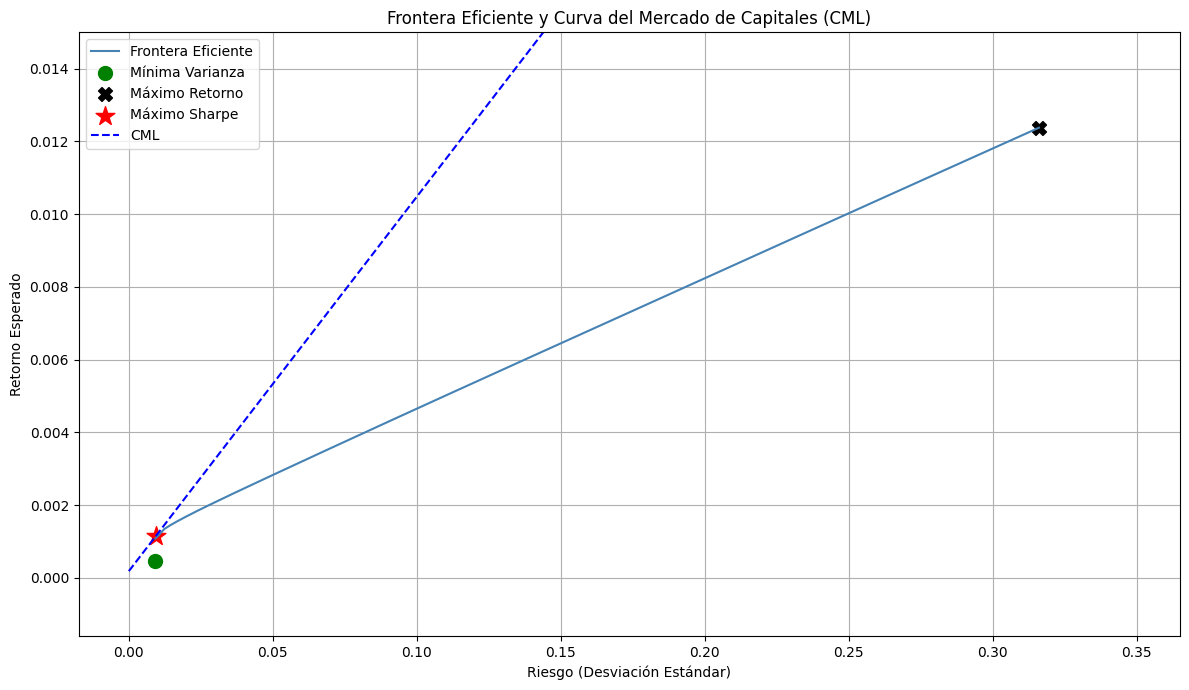

In [12]:
frontier, portfolios = efficient_frontier_por_riesgo(mean_returns, cov_matrix, res_min_var, res_max_ret, num_points=300)

plt.figure(figsize=(12, 7))
plt.plot(frontier[0, :], frontier[1, :], label='Frontera Eficiente', color='steelblue')

# Portafolios especiales
ret_min_var, risk_min_var = portfolio_performance(res_min_var.x, mean_returns, cov_matrix)
ret_max_ret, risk_max_ret = portfolio_performance(res_max_ret.x, mean_returns, cov_matrix)
ret_max_sharpe, risk_max_sharpe = portfolio_performance(res_max_sharpe.x, mean_returns, cov_matrix)

plt.scatter(risk_min_var, ret_min_var, marker='o', color='g', s=100, label='Mínima Varianza')
plt.scatter(risk_max_ret, ret_max_ret, marker='X', color='black', s=100, label='Máximo Retorno')
plt.scatter(risk_max_sharpe, ret_max_sharpe, marker='*', color='red', s=200, label='Máximo Sharpe')

# CML
x = np.linspace(0, max(frontier[0]) * 1.1, 100)
cml = rf + ((ret_max_sharpe - rf) / risk_max_sharpe) * x
plt.plot(x, cml, linestyle='--', color='blue', label='CML')

plt.title('Frontera Eficiente y Curva del Mercado de Capitales (CML)')
plt.xlabel('Riesgo (Desviación Estándar)')
plt.ylabel('Retorno Esperado')
plt.ylim(top=0.015)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

### Ajustada

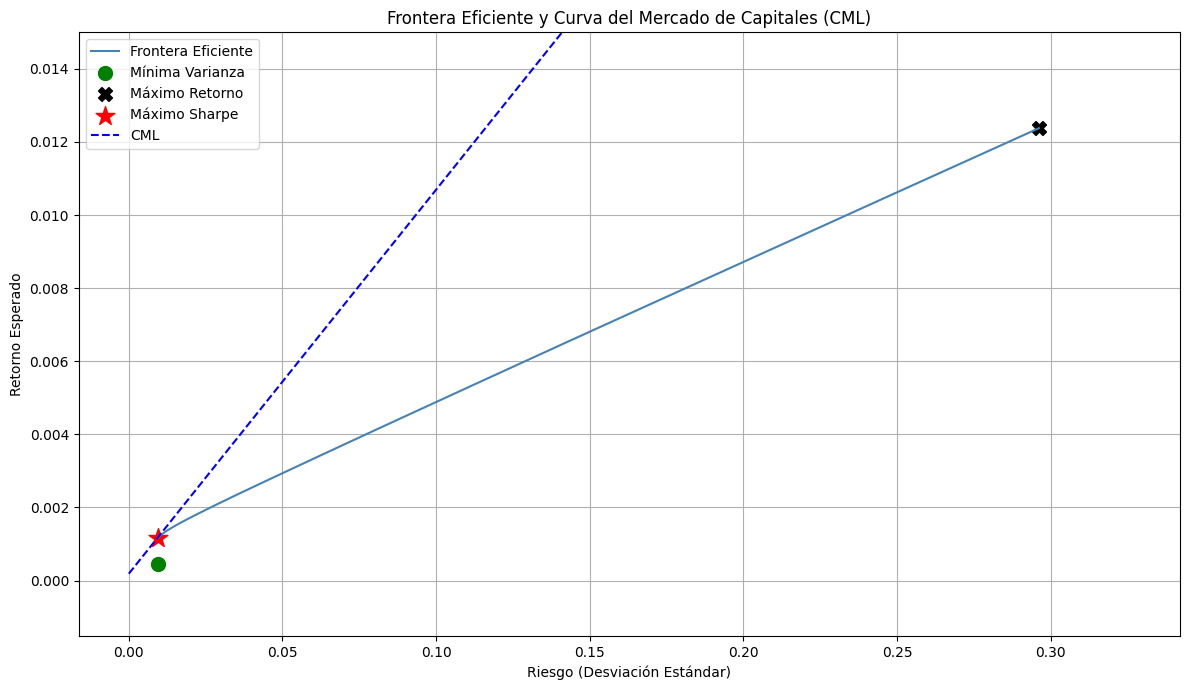

In [13]:
frontier_adj, portfolios_adj = efficient_frontier_por_riesgo(mean_returns, cov_ajustada, res_min_var_adj, res_max_ret_adj, num_points=300)

plt.figure(figsize=(12, 7))
plt.plot(frontier_adj[0, :], frontier_adj[1, :], label='Frontera Eficiente', color='steelblue')

# Portafolios especiales
ret_min_var_adj, risk_min_var_adj = portfolio_performance(res_min_var_adj.x, mean_returns, cov_ajustada)
ret_max_ret_adj, risk_max_ret_adj = portfolio_performance(res_max_ret_adj.x, mean_returns, cov_ajustada)
ret_max_sharpe_adj, risk_max_sharpe_adj = portfolio_performance(res_max_sharpe_adj.x, mean_returns, cov_ajustada)

plt.scatter(risk_min_var_adj, ret_min_var_adj, marker='o', color='g', s=100, label='Mínima Varianza')
plt.scatter(risk_max_ret_adj, ret_max_ret_adj, marker='X', color='black', s=100, label='Máximo Retorno')
plt.scatter(risk_max_sharpe_adj, ret_max_sharpe_adj, marker='*', color='red', s=200, label='Máximo Sharpe')

# CML
x = np.linspace(0, max(frontier_adj[0]) * 1.1, 100)
cml = rf + ((ret_max_sharpe_adj - rf) / risk_max_sharpe_adj) * x
plt.plot(x, cml, linestyle='--', color='blue', label='CML')

plt.title('Frontera Eficiente y Curva del Mercado de Capitales (CML)')
plt.xlabel('Riesgo (Desviación Estándar)')
plt.ylabel('Retorno Esperado')
plt.ylim(top=0.015)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [14]:
def efficient_frontier_por_retorno(mean_returns, cov_matrix, ret_min, ret_max, num_points=300):
    results = np.zeros((2, num_points))
    weights_record = []

    # Retornos objetivo
    target_returns = np.linspace(ret_min, ret_max, num_points)
    num_assets = len(mean_returns)

    bounds = tuple((0, 1) for _ in range(num_assets))
    initial_guess = np.ones(num_assets) / num_assets

    for idx, target_ret in enumerate(target_returns):
        constraints = (
            {'type': 'eq', 'fun': lambda x: np.sum(x) - 1},
            {'type': 'eq', 'fun': lambda x: np.dot(x, mean_returns) - target_ret}
        )

        result = minimize(min_variance, initial_guess, args=(cov_matrix,),
                          method='SLSQP', bounds=bounds, constraints=constraints)

        if result.success:
            weights = result.x
            risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
            ret = np.dot(weights, mean_returns)

            results[0, idx] = risk
            results[1, idx] = ret
            weights_record.append(weights)

            initial_guess = weights  # Mejora de estabilidad

    return results, weights_record


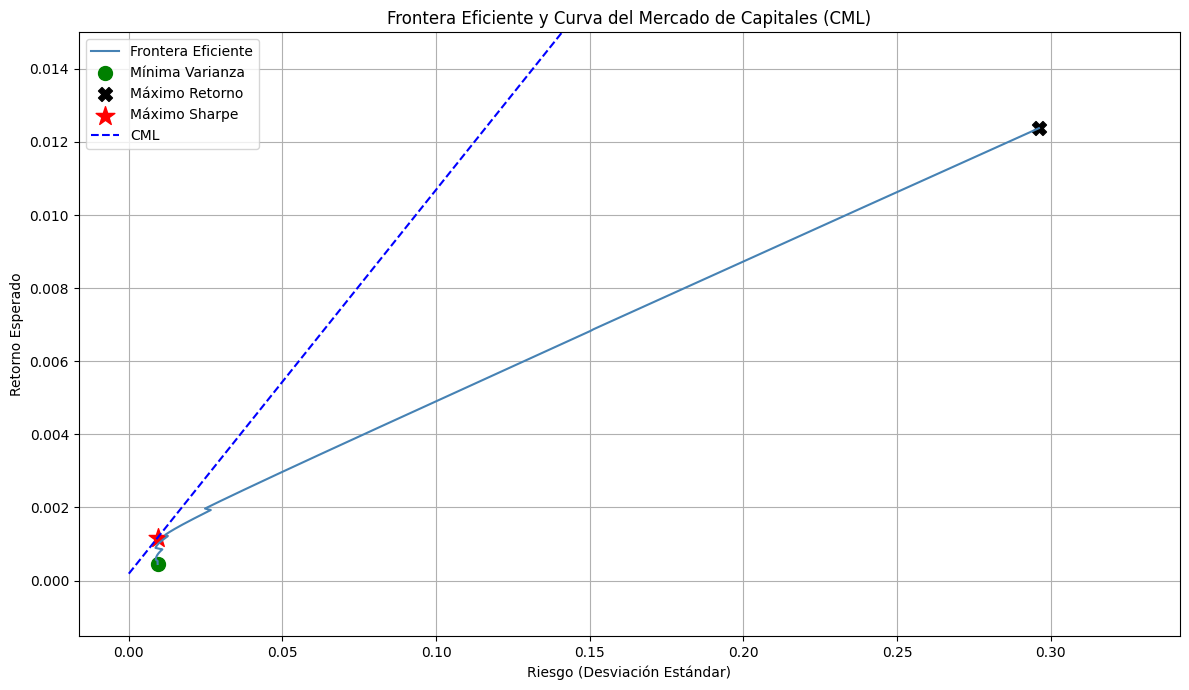

In [15]:
ret_min = np.dot(res_min_var_adj.x, mean_returns)
ret_max = np.dot(res_max_ret_adj.x, mean_returns)

frontier, portfolios = efficient_frontier_por_retorno(mean_returns, cov_ajustada, ret_min, ret_max)
plt.figure(figsize=(12, 7))
plt.plot(frontier[0, :], frontier[1, :], label='Frontera Eficiente', color='steelblue')

# Portafolios especiales
ret_min_var, risk_min_var = portfolio_performance(res_min_var_adj.x, mean_returns, cov_ajustada)
ret_max_ret, risk_max_ret = portfolio_performance(res_max_ret_adj.x, mean_returns, cov_ajustada)
ret_max_sharpe, risk_max_sharpe = portfolio_performance(res_max_sharpe_adj.x, mean_returns, cov_ajustada)

plt.scatter(risk_min_var, ret_min_var, marker='o', color='g', s=100, label='Mínima Varianza')
plt.scatter(risk_max_ret, ret_max_ret, marker='X', color='black', s=100, label='Máximo Retorno')
plt.scatter(risk_max_sharpe, ret_max_sharpe, marker='*', color='red', s=200, label='Máximo Sharpe')

# CML
x = np.linspace(0, max(frontier[0]) * 1.1, 100)
cml = rf + ((ret_max_sharpe - rf) / risk_max_sharpe) * x
plt.plot(x, cml, linestyle='--', color='blue', label='CML')

plt.title('Frontera Eficiente y Curva del Mercado de Capitales (CML)')
plt.xlabel('Riesgo (Desviación Estándar)')
plt.ylabel('Retorno Esperado')
plt.ylim(top=0.015)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

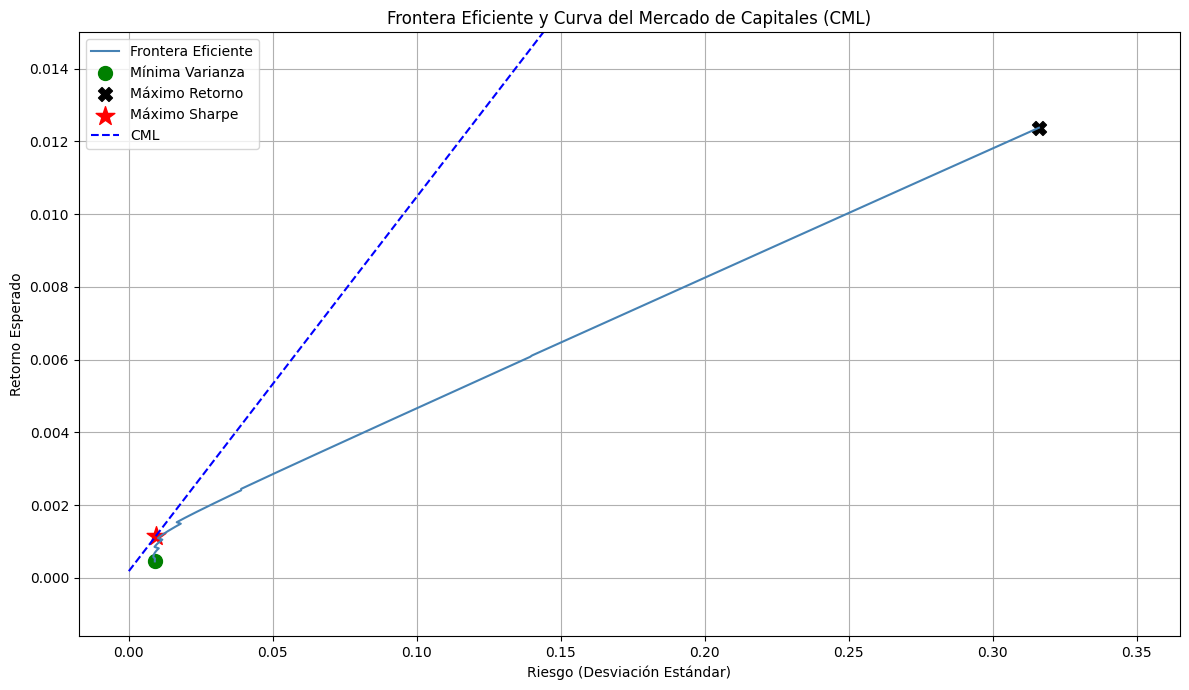

In [16]:
ret_min = np.dot(res_min_var.x, mean_returns)
ret_max = np.dot(res_max_ret.x, mean_returns)

frontier, portfolios = efficient_frontier_por_retorno(mean_returns, cov_matrix, ret_min, ret_max)
plt.figure(figsize=(12, 7))
plt.plot(frontier[0, :], frontier[1, :], label='Frontera Eficiente', color='steelblue')

# Portafolios especiales
ret_min_var, risk_min_var = portfolio_performance(res_min_var.x, mean_returns, cov_matrix)
ret_max_ret, risk_max_ret = portfolio_performance(res_max_ret.x, mean_returns, cov_matrix)
ret_max_sharpe, risk_max_sharpe = portfolio_performance(res_max_sharpe.x, mean_returns, cov_matrix)

plt.scatter(risk_min_var, ret_min_var, marker='o', color='g', s=100, label='Mínima Varianza')
plt.scatter(risk_max_ret, ret_max_ret, marker='X', color='black', s=100, label='Máximo Retorno')
plt.scatter(risk_max_sharpe, ret_max_sharpe, marker='*', color='red', s=200, label='Máximo Sharpe')

# CML
x = np.linspace(0, max(frontier[0]) * 1.1, 100)
cml = rf + ((ret_max_sharpe - rf) / risk_max_sharpe) * x
plt.plot(x, cml, linestyle='--', color='blue', label='CML')

plt.title('Frontera Eficiente y Curva del Mercado de Capitales (CML)')
plt.xlabel('Riesgo (Desviación Estándar)')
plt.ylabel('Retorno Esperado')
plt.ylim(top=0.015)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Simulaciones

In [51]:
# Cargar los datos
df = pd.read_excel("Datos_Portafolio_Markowitz.xlsx", sheet_name="Retornos_Log")
retornos = df.set_index("Fecha")
retornos.index = pd.to_datetime(retornos.index)
retornos = retornos.drop(columns=["IPSA"])
# Separar periodos
retornos_entrenamiento = retornos[(retornos.index.year >= 2022) & (retornos.index.year <= 2024)]
retornos_2025 = retornos[retornos.index.year == 2025]

# Parámetros
rf = 0.0474 / 252  # tasa libre de riesgo diaria
num_assets = retornos.shape[1]
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

In [52]:
# Funciones de optimización
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, risk

def min_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

In [53]:
# Simulación diaria
retornos_diarios_portafolio = []

for fecha in retornos_2025.index:
    datos_hasta_hoy = retornos_entrenamiento[retornos_entrenamiento.index < fecha]
    
    if len(datos_hasta_hoy) < 2:
        continue

    mean_returns = datos_hasta_hoy.mean()
    cov_matrix = datos_hasta_hoy.cov()

    res = minimize(min_variance, initial_guess, args=(cov_matrix,),
                   method='SLSQP', bounds=bounds, constraints=constraints)

    if not res.success:
        continue

    pesos = res.x
    retorno_dia = np.dot(pesos, retornos_2025.loc[fecha])
    retornos_diarios_portafolio.append((fecha, retorno_dia))

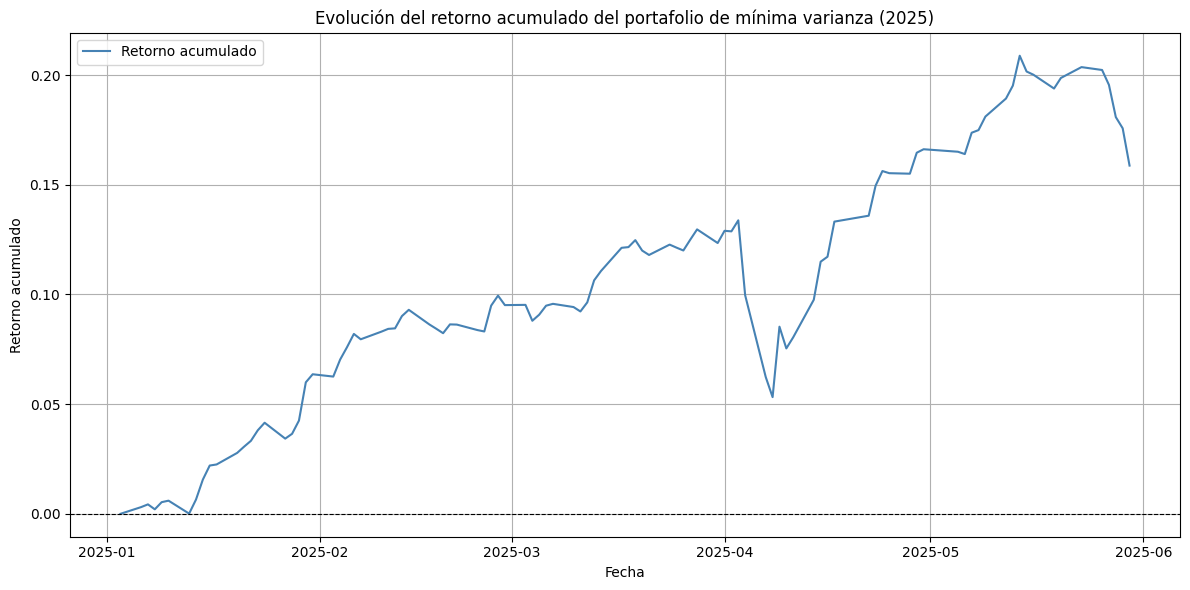

In [54]:
# Convertir resultados a DataFrame
df_simulacion = pd.DataFrame(retornos_diarios_portafolio, columns=["Fecha", "Retorno"])
df_simulacion["Retorno_Acumulado"] = (1 + df_simulacion["Retorno"]).cumprod() - 1

# Mostrar gráfico
plt.figure(figsize=(12, 6))
plt.plot(df_simulacion["Fecha"], df_simulacion["Retorno_Acumulado"], label="Retorno acumulado", color="steelblue")
plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Evolución del retorno acumulado del portafolio de mínima varianza (2025)")
plt.xlabel("Fecha")
plt.ylabel("Retorno acumulado")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


## Simulación Ajustada

In [55]:
# Funciones
def portfolio_performance(weights, mean_returns, cov_matrix):
    ret = np.dot(weights, mean_returns)
    risk = np.sqrt(np.dot(weights.T, np.dot(cov_matrix, weights)))
    return ret, risk

def min_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

In [87]:
# --- CARGAR DATOS ---
df = pd.read_excel("Datos_Portafolio_Markowitz.xlsx", sheet_name="Retornos_Log")
df_prob = pd.read_excel("Datos_Portafolio_Markowitz.xlsx", sheet_name="Probabilidades")

retornos = df.set_index("Fecha")
retornos.index = pd.to_datetime(retornos.index)
retornos = retornos.drop(columns=["IPSA"])
retornos.columns = retornos.columns.str.strip().str.replace(".", "-")
df_prob["Activo"] = df_prob["Activo"].str.strip()

# Filtrar activos comunes
activos_comunes = list(set(retornos.columns).intersection(df_prob["Activo"]))
retornos = retornos[activos_comunes]
df_prob = df_prob.set_index("Activo").loc[activos_comunes]


# Separar periodos
retornos_entrenamiento = retornos[(retornos.index.year >= 2022) & (retornos.index.year <= 2024)]
retornos_2025 = retornos[retornos.index.year == 2025]

# Parámetros
rf = 0.0474 / 252  # tasa libre de riesgo diaria
num_assets = retornos.shape[1]
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]


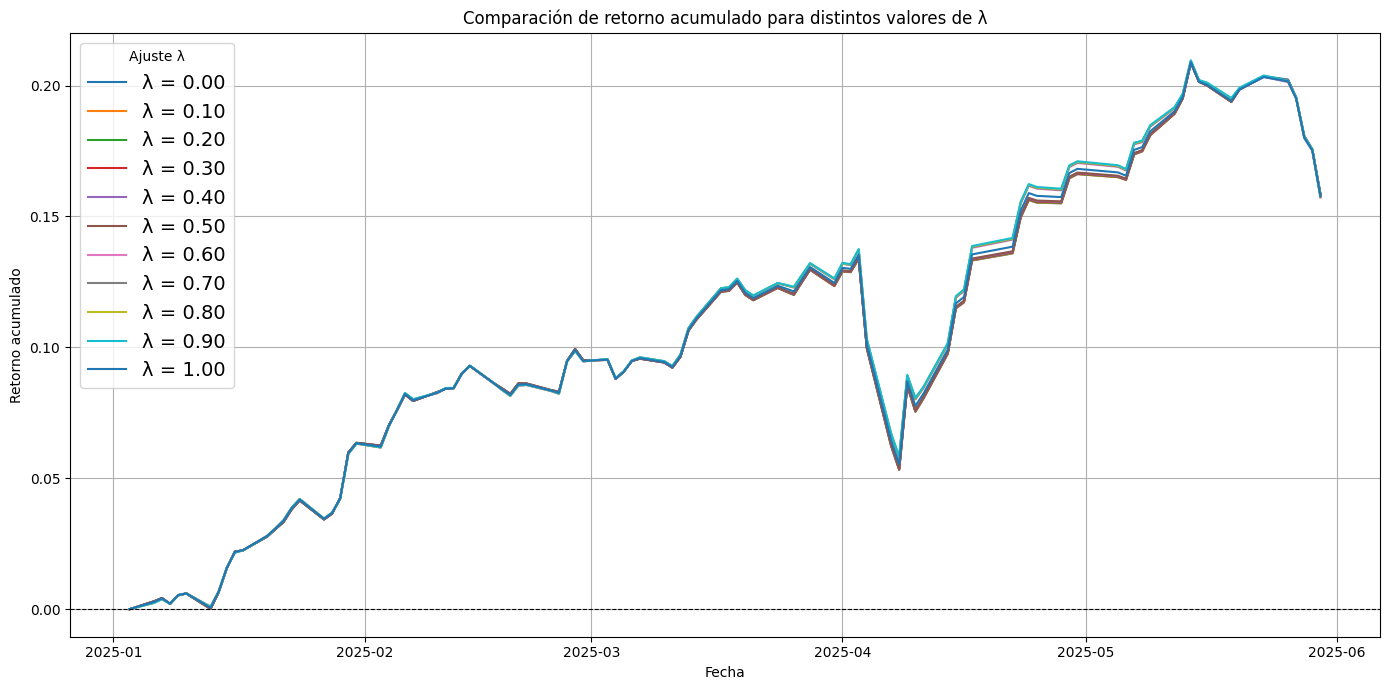

In [88]:
# --- SIMULACIÓN PARA GRID DE LAMBDA ---
lambdas = np.arange(0.0, 1.01, 0.1)
resultados_lambdas = {}

for lambda_ in lambdas:
    retornos_diarios_portafolio = []
    
    for fecha in retornos_2025.index:
        datos_hasta_hoy = retornos_entrenamiento[retornos_entrenamiento.index < fecha]
        
        if len(datos_hasta_hoy) < 2:
            continue

        mean_returns = datos_hasta_hoy.mean()
        cov_matrix_corr = datos_hasta_hoy.corr()
        std_original = datos_hasta_hoy.std()
        
        # Aplicar ajuste dinámico
        ajuste = df_prob["Ajuste"]
        std_ajustada = std_original * (1 - lambda_ * ajuste)

        # Matriz de covarianza ajustada
        cov_ajustada = np.outer(std_ajustada, std_ajustada) * cov_matrix_corr
        cov_ajustada = pd.DataFrame(cov_ajustada, index=activos_comunes, columns=activos_comunes)

        # Optimización
        res = minimize(min_variance, initial_guess, args=(cov_ajustada,),
                       method='SLSQP', bounds=bounds, constraints=constraints)
        
        if not res.success:
            continue

        pesos = res.x
        retorno_dia = np.dot(pesos, retornos_2025.loc[fecha, activos_comunes].values)
        retornos_diarios_portafolio.append((fecha, retorno_dia))
    # Guardar resultados
    df_resultado = pd.DataFrame(retornos_diarios_portafolio, columns=["Fecha", "Retorno"])
    df_resultado["Retorno_Acumulado"] = (1 + df_resultado["Retorno"]).cumprod() - 1
    resultados_lambdas[lambda_] = df_resultado

# --- GRAFICAR TODOS LOS RETORNOS ACUMULADOS ---
plt.figure(figsize=(14, 7))

for lambda_, df_sim in resultados_lambdas.items():
    plt.plot(df_sim["Fecha"], df_sim["Retorno_Acumulado"], label=f"λ = {lambda_:.2f}")

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Comparación de retorno acumulado para distintos valores de λ")
plt.xlabel("Fecha")
plt.ylabel("Retorno acumulado")
plt.grid(True)
plt.legend(title="Ajuste λ", fontsize=14)
plt.tight_layout()
plt.show()


In [70]:
series = pd.concat([std_original, std_ajustada], axis = 1)
series

,0,1
SECURITY,0.015563,0.011166
MALLPLAZA,0.018307,0.016700
CAP,0.023576,0.033719
CCU,0.016279,0.022423
BCI,0.015562,0.020733
CHILE,0.013420,0.012113
PARAUCO,0.018530,0.015019
RIPLEY,0.018196,0.023061
COPEC,0.017187,0.024405
ENELAM,0.014456,0.013935


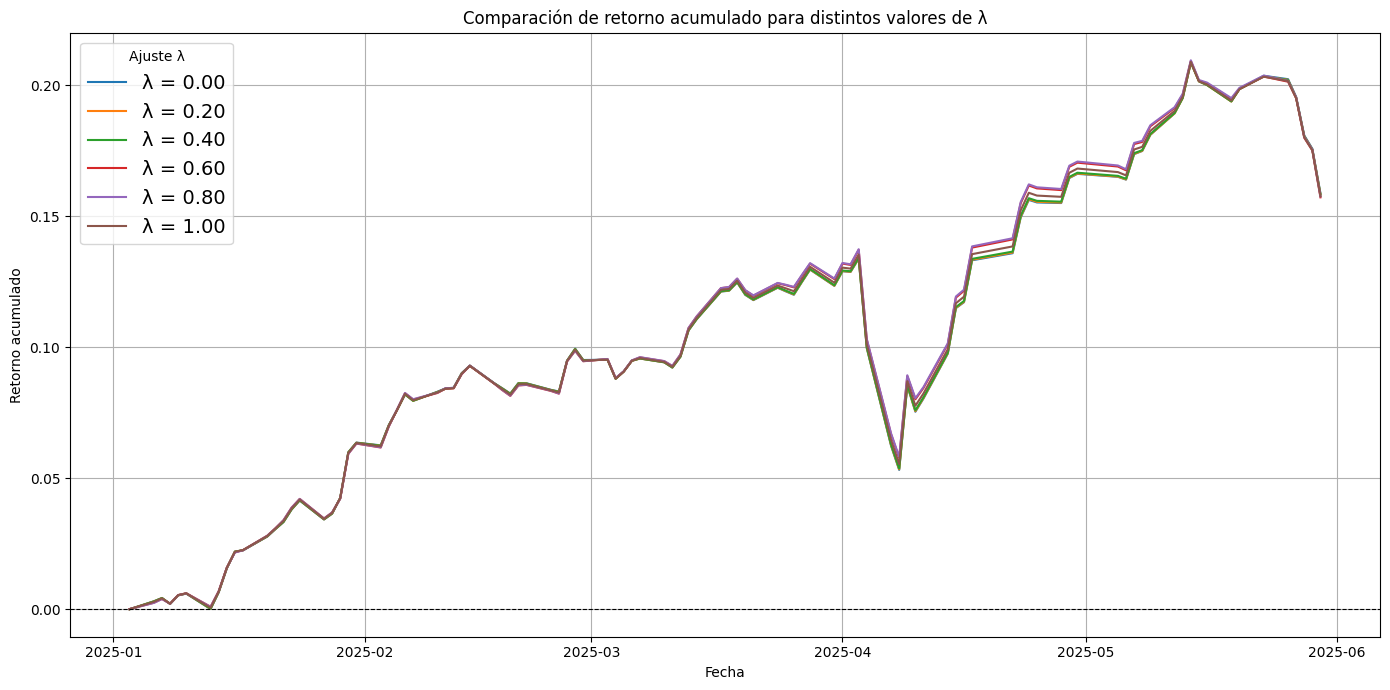

In [89]:
# --- SIMULACIÓN PARA GRID DE LAMBDA ---
lambdas = np.arange(0.0, 1.01, 0.2)
resultados_lambdas = {}

for lambda_ in lambdas:
    retornos_diarios_portafolio = []
    
    for fecha in retornos_2025.index:
        datos_hasta_hoy = retornos_entrenamiento[retornos_entrenamiento.index < fecha]
        
        if len(datos_hasta_hoy) < 2:
            continue

        mean_returns = datos_hasta_hoy.mean()
        cov_matrix_corr = datos_hasta_hoy.corr()
        std_original = datos_hasta_hoy.std()
        
        # Aplicar ajuste dinámico
        ajuste = df_prob["Ajuste"]
        std_ajustada = std_original * (1 - lambda_ * ajuste)

        # Matriz de covarianza ajustada
        cov_ajustada = np.outer(std_ajustada, std_ajustada) * cov_matrix_corr
        cov_ajustada = pd.DataFrame(cov_ajustada, index=activos_comunes, columns=activos_comunes)

        # Optimización
        res = minimize(min_variance, initial_guess, args=(cov_ajustada,),
                       method='SLSQP', bounds=bounds, constraints=constraints)
        
        if not res.success:
            continue

        pesos = res.x
        retorno_dia = np.dot(pesos, retornos_2025.loc[fecha, activos_comunes].values)
        retornos_diarios_portafolio.append((fecha, retorno_dia))
    # Guardar resultados
    df_resultado = pd.DataFrame(retornos_diarios_portafolio, columns=["Fecha", "Retorno"])
    df_resultado["Retorno_Acumulado"] = (1 + df_resultado["Retorno"]).cumprod() - 1
    resultados_lambdas[lambda_] = df_resultado

# --- GRAFICAR TODOS LOS RETORNOS ACUMULADOS ---
plt.figure(figsize=(14, 7))

for lambda_, df_sim in resultados_lambdas.items():
    plt.plot(df_sim["Fecha"], df_sim["Retorno_Acumulado"], label=f"λ = {lambda_:.2f}")

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Comparación de retorno acumulado para distintos valores de λ")
plt.xlabel("Fecha")
plt.ylabel("Retorno acumulado")
plt.grid(True)
plt.legend(title="Ajuste λ", fontsize=14)
plt.tight_layout()
plt.show()

In [79]:
mean_returns

SECURITY      0.001139
MALLPLAZA     0.000856
CAP          -0.000707
CCU          -0.000045
BCI           0.000337
CHILE         0.000741
PARAUCO       0.001119
RIPLEY        0.001187
COPEC        -0.000049
ENELAM        0.000024
ECL           0.000896
LTM          -0.003190
AGUAS-A       0.001048
BSANTANDER    0.000583
IAM           0.000883
COLBUN        0.000828
ENELCHILE     0.000933
SMU           0.001052
SALFACORP     0.000876
FALABELLA     0.000528
CMPC          0.000061
ENTEL         0.000197
CENCOSUD      0.000876
ANDINA-B      0.000669
ITAUCL        0.012378
VAPORES      -0.000323
SONDA         0.000734
CONCHATORO   -0.000122
QUINENCO      0.001059
SQM-B         0.000126
dtype: float64

In [77]:
mean_returns

SECURITY      0.810662
MALLPLAZA     0.609168
CAP          -0.503531
CCU          -0.032320
BCI           0.240285
CHILE         0.527690
PARAUCO       0.796891
RIPLEY        0.845332
COPEC        -0.035104
ENELAM        0.017263
ECL           0.637888
LTM          -2.271048
AGUAS-A       0.745836
BSANTANDER    0.415332
IAM           0.628701
COLBUN        0.589567
ENELCHILE     0.664247
SMU           0.748867
SALFACORP     0.623615
FALABELLA     0.376044
CMPC          0.043682
ENTEL         0.140359
CENCOSUD      0.623953
ANDINA-B      0.476232
ITAUCL        8.812787
VAPORES      -0.229631
SONDA         0.522340
CONCHATORO   -0.087125
QUINENCO      0.753879
SQM-B         0.089850
dtype: float64

In [80]:
# Desplazar un día para incluir desde el día siguiente del mes anterior
retornos_shifted = retornos.shift(-1)

# Calcular retornos mensuales como suma de log-retornos diarios
retornos_mensuales = retornos_shifted.resample("MS").apply(lambda x: x.sum(skipna=True))

# Mostrar primeros valores
print(retornos_mensuales.head())

            SECURITY  MALLPLAZA       CAP       CCU       BCI     CHILE  \
Fecha                                                                     
2022-01-01  0.006590   0.078439  0.110655 -0.051128  0.120714  0.122678   
2022-02-01 -0.014889  -0.086574 -0.013688 -0.100193 -0.083273  0.031633   
2022-03-01  0.044256  -0.020036  0.292478 -0.008680  0.039869  0.017569   
2022-04-01 -0.109484  -0.076916 -0.189607 -0.047953 -0.011460 -0.001439   
2022-05-01  0.095061   0.032576  0.075508  0.045522  0.138180  0.008182   

             PARAUCO    RIPLEY     COPEC    ENELAM  ...      CMPC     ENTEL  \
Fecha                                               ...                       
2022-01-01  0.084248  0.198367  0.041879  0.008397  ...  0.068993  0.122876   
2022-02-01 -0.186425 -0.221506 -0.083544 -0.024013  ... -0.110337 -0.127468   
2022-03-01  0.098892  0.061551  0.064725  0.022025  ...  0.115136  0.179499   
2022-04-01 -0.146878 -0.066027 -0.024130 -0.041628  ... -0.111090 -0.068061   


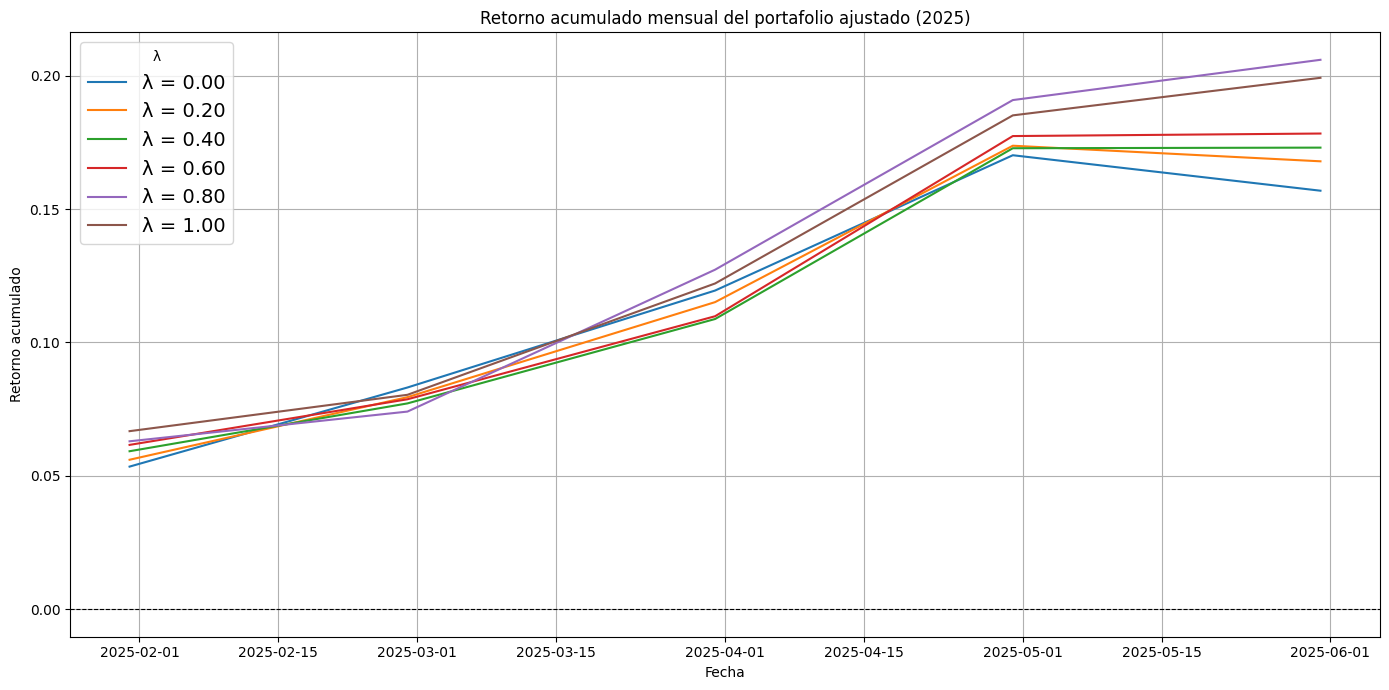

In [91]:
# --- Funciones ---
def min_variance(weights, cov_matrix):
    return np.dot(weights.T, np.dot(cov_matrix, weights))

# --- Cargar datos ---
df = pd.read_excel("Datos_Portafolio_Markowitz.xlsx", sheet_name="Retornos_Log")
df_prob = pd.read_excel("Datos_Portafolio_Markowitz.xlsx", sheet_name="Probabilidades")

retornos = df.set_index("Fecha")
retornos.index = pd.to_datetime(retornos.index)
retornos = retornos.drop(columns=["IPSA"])
retornos.columns = retornos.columns.str.strip().str.replace(".", "-")
# Desplazar un día para incluir desde el día siguiente del mes anterior
retornos_shifted = retornos.shift(-1)

# Calcular retornos mensuales como suma de log-retornos diarios
retornos = retornos_shifted.resample("MS").apply(lambda x: x.sum(skipna=True))

df_prob["Activo"] = df_prob["Activo"].str.strip()

# Filtrar activos comunes
activos_comunes = list(set(retornos.columns).intersection(df_prob["Activo"]))
retornos = retornos[activos_comunes]

df_prob = df_prob.set_index("Activo").loc[activos_comunes]

# Separar periodos
retornos_entrenamiento = retornos[(retornos.index.year >= 2022) & (retornos.index.year <= 2024)]
retornos_2025 = retornos[retornos.index.year == 2025]

# Parámetros
rf = 0.0474 / 252
num_assets = len(activos_comunes)
constraints = {'type': 'eq', 'fun': lambda x: np.sum(x) - 1}
bounds = tuple((0, 1) for _ in range(num_assets))
initial_guess = num_assets * [1. / num_assets]

# --- Simulación mensual para grid de lambda ---
lambdas = np.arange(0.0, 1.01, 0.2)
resultados_mensuales = {}

# Obtener el primer día hábil de cada mes en 2025
primeros_dias_mes = retornos_2025.resample('MS').first().dropna().index

for lambda_ in lambdas:
    retornos_portafolio = []
    
    for fecha in primeros_dias_mes:
        datos_hasta_hoy = retornos_entrenamiento[retornos_entrenamiento.index < fecha]
        if len(datos_hasta_hoy) < 2:
            continue

        mean_returns = datos_hasta_hoy.mean()
        cov_corr = datos_hasta_hoy.corr()
        std_original = datos_hasta_hoy.std()
        ajuste = df_prob["Ajuste"]
        std_ajustada = std_original * (1 - lambda_ * ajuste)
        cov_ajustada = np.outer(std_ajustada, std_ajustada) * cov_corr
        cov_ajustada = pd.DataFrame(cov_ajustada, index=activos_comunes, columns=activos_comunes)

        res = minimize(min_variance, initial_guess, args=(cov_ajustada,),
                       method='SLSQP', bounds=bounds, constraints=constraints)
        
        if not res.success:
            continue

        pesos = res.x

        # Obtener retornos diarios desde fecha hasta fin de mes
        inicio = fecha
        fin = fecha + pd.offsets.MonthEnd(0)
        datos_mes = retornos_2025[(retornos_2025.index >= inicio) & (retornos_2025.index <= fin)]

        if datos_mes.empty:
            continue

        # Calcular retorno acumulado del mes (compuesto)
        retornos_dia = np.dot(datos_mes[activos_comunes].values, pesos)
        retorno_mes = (1 + retornos_dia).prod() - 1
        retornos_portafolio.append((fin, retorno_mes))

    # Crear DataFrame con resultados
    df_resultado = pd.DataFrame(retornos_portafolio, columns=["Fecha", "Retorno"])
    df_resultado["Retorno_Acumulado"] = (1 + df_resultado["Retorno"]).cumprod() - 1
    resultados_mensuales[lambda_] = df_resultado

# --- Graficar ---
plt.figure(figsize=(14, 7))
for lambda_, df_sim in resultados_mensuales.items():
    plt.plot(df_sim["Fecha"], df_sim["Retorno_Acumulado"], label=f"λ = {lambda_:.2f}")

plt.axhline(0, color="black", linestyle="--", linewidth=0.8)
plt.title("Retorno acumulado mensual del portafolio ajustado (2025)")
plt.xlabel("Fecha")
plt.ylabel("Retorno acumulado")
plt.grid(True)
plt.legend(title="λ", fontsize=14)
plt.tight_layout()
plt.show()
